In [1]:
import datetime
import math
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

2023-03-30 20:26:15.803118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = yf.download('GOOG', start=None, end=None)
print(df.shape)

[*********************100%***********************]  1 of 1 completed
(4685, 6)


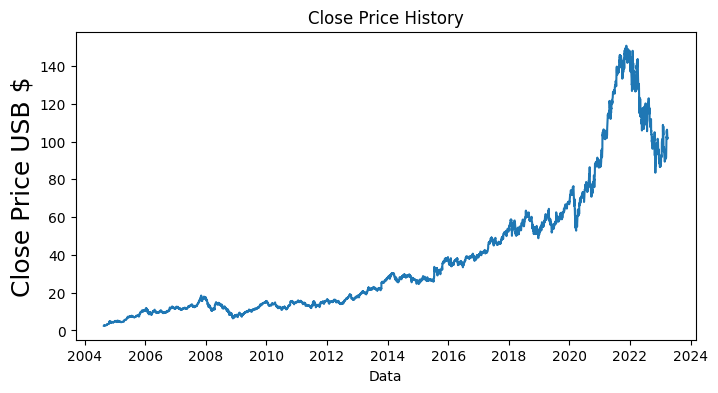

In [3]:
#Visualise closing data
plt.figure(figsize=(8,4))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Data', fontsize=10)
plt.ylabel('Close Price USB $', fontsize=18)
plt.show()

#Creating dataframe with close
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8 )

training_data_len

#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

train_data = scaled_data[0:training_data_len, :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0 ])
    y_train.append(train_data[i, 0])
    # if i<= 61:
        # print(x_train)
        # print(y_train)
        # print()

#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshaping the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [4]:
print(x_train.shape)
print(y_train.shape)

(3688, 60, 1)
(3688,)


In [5]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=8, epochs=4)

2023-03-30 20:26:25.089452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/4
461/461 [==============================] - 17s 27ms/step - loss: 2.4694e-04
Epoch 2/4
461/461 [==============================] - 12s 27ms/step - loss: 6.3284e-05
Epoch 3/4
461/461 [==============================] - 13s 29ms/step - loss: 5.5079e-05
Epoch 4/4
461/461 [==============================] - 14s 30ms/step - loss: 5.7271e-05


In [6]:
#Create the testing data set
#Create a new array containing scaled values 
test_data = scaled_data[training_data_len - 60:, :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

#Convert the data to a numpy array
x_test = np.array(x_test)

#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

#Evaluate our model getting RMSE root mean squared error
rmse = np.sqrt(np.mean(predictions - y_test )**2)
rmse

30/30 [==============================] - 1s 16ms/step


2.232132992087968

/var/folders/63/t81zr1qj6ybdhjqh0hnknjpm0000gn/T/ipykernel_10283/1082951998.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


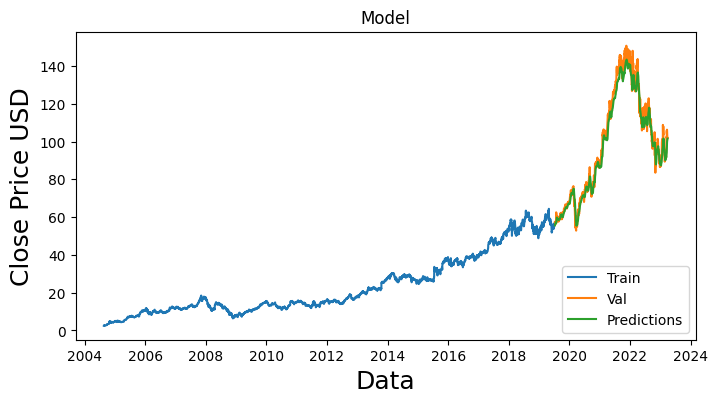

In [7]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Vis the dat
plt.figure(figsize=(8,4))
plt.title('Model')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()